In [1]:
pip install pandas matplotlib seaborn numpy scipy statsmodels scikits.bootstrap

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy
from scipy import stats
import scipy
import helper.cliffs_delta as cliff
import statsmodels.api as sm
import itertools
import scikits.bootstrap as boot

# Table of contents
1. [RQ1: JS vs. WASM Energy Consumption](#rq1)
2. [RQ2: JS Browsers Energy Consumption](#rq2js)
3. [RQ2: WASM Browsers Energy Consumption](#rq2wasm)

# Prepare Data

In [3]:
sns.set(rc = {'figure.figsize':(10,10)})
confidence_level = 0.95

df = pd.read_csv('./data/energy.csv',sep=';',quotechar='"',names=["browser", "language", "algorithm", "device", "energy"])
df['energy_total'] = df['energy'].astype(float)
df['implementation'] = numpy.where(df['language'] == 'js', 'js', 'wasm')

## unique values in columns
browsers = numpy.sort(df['browser'].unique())
browserpairs = list(itertools.combinations(browsers, 2))
languages = df['language'].unique()
implementations = numpy.sort(df['implementation'].unique())
implementationpairs = list(itertools.combinations(implementations, 2))
languagepairs = list(itertools.combinations(languages, 2))
algorithms = df['algorithm'].unique()
devices = df['device'].unique()

df.head()

,browser,language,algorithm,device,energy,energy_total,implementation
0,firefox,c,fibonacci,SM-G991B,6.531442,6.531442,wasm
1,chrome,c,humblenumbers,SM-G991B,5.787359,5.787359,wasm
2,chrome,js,matrixmultiplication,SM-G991B,9.739240,9.739240,js
3,chrome,js,seqnonsquares,SM-G991B,4.516185,4.516185,js
4,chrome,js,nqueens,SM-G991B,5.935186,5.935186,js


## Count samples

In [4]:
data = []

for browser in browsers:
    for language in languages:
        for algorithm in algorithms:
            for device in devices:
                #print(browser,device,numpy.mean(df[(df['browser'] == browser) & (df['language'] == language) & (df['algorithm'] == algorithm) & (df['device'] == device)]['energy']))
                data.append(
                    [browser, language, algorithm, device, df[(df['browser'] == browser) & (df['language'] == language) & (df['algorithm'] == algorithm) & (df['device'] == device)]['energy_total'].count()]
                )

# Create the pandas DataFrame
count = pd.DataFrame(data, columns = ['browser', 'language', 'algorithm', 'device', 'count'])
print(count.to_string())

     browser language             algorithm    device  count
0     chrome        c             fibonacci  SM-G991B     30
1     chrome        c             fibonacci   Nexus 5     32
2     chrome        c         humblenumbers  SM-G991B     31
3     chrome        c         humblenumbers   Nexus 5     34
4     chrome        c  matrixmultiplication  SM-G991B     31
5     chrome        c  matrixmultiplication   Nexus 5     32
6     chrome        c         seqnonsquares  SM-G991B     31
7     chrome        c         seqnonsquares   Nexus 5     33
8     chrome        c               nqueens  SM-G991B     30
9     chrome        c               nqueens   Nexus 5     31
10    chrome        c            bubblesort  SM-G991B     32
11    chrome        c            bubblesort   Nexus 5     34
12    chrome        c        perfectnumbers  SM-G991B     31
13    chrome        c        perfectnumbers   Nexus 5     33
14    chrome        c         insertionsort  SM-G991B     31
15    chrome        c   

## Total Energy

In [5]:
data = []
for device in devices:
    for implementation in implementations:
        x = df[(df['device'] == device) & (df['implementation'] == implementation)]
        sum = numpy.round(numpy.sum(x['energy']), 2)

        data.append(
            [device, implementation, sum]
        )
        
# Create the pandas DataFrame
stat = pd.DataFrame(data, columns = ['device', 'implementation', 'sum'])
print(stat.to_string())

     device implementation       sum
0  SM-G991B             js   9638.40
1  SM-G991B           wasm   7110.95
2   Nexus 5             js  14852.36
3   Nexus 5           wasm  11826.85


# Violinplot (Algorithms)

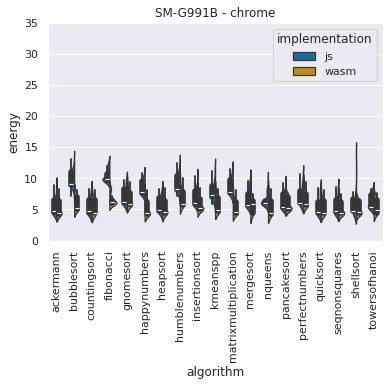

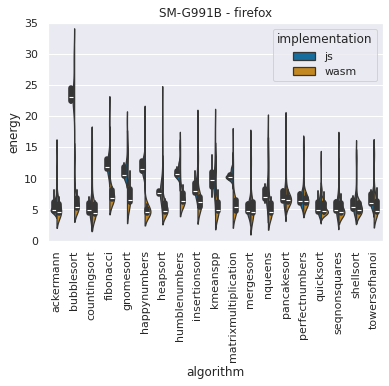

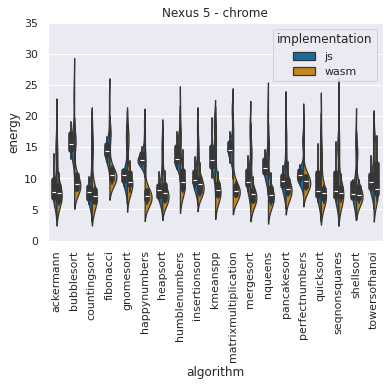

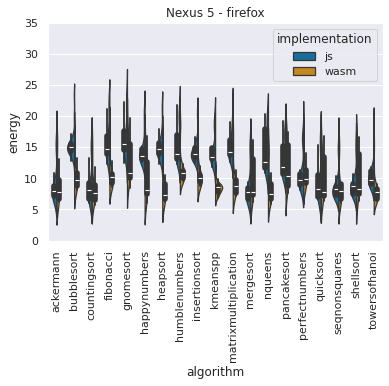

In [6]:
for device in devices:
    for browser in browsers:
        data = df[(df['device'] == device) & (df['browser'] == browser)].sort_values(by=['algorithm'])
        plt.figure()
        plt.xticks(rotation=90)
        plt.ylim(0, 35)
        sns.violinplot(x='algorithm', y='energy', hue='implementation', hue_order=implementations, data=data, palette='colorblind', split=True).set_title(device + " - " + browser)

# RQ1: JavaScript vs. WebAssembly <a name="rq1"></a>

## Shapiro Wilk Test

In [7]:
data = []
non_normal = 0

for implementation in implementations:
    energy = df[(df['implementation'] == implementation)]['energy']

    if len(energy) >= 3:
        shapiro_test = stats.shapiro(energy)

        non_normal += (1 if shapiro_test.pvalue <= 0.05 else 0)

        data.append(
            [implementation,
             shapiro_test.statistic,
             shapiro_test.pvalue
            ]
        )
        
# Create the pandas DataFrame
swt = pd.DataFrame(data, columns = ['implementation', 'w', 'p'])
#print(swt.to_string())
display(swt)

print("\n{} non-normally distributed samples".format(non_normal))
print("{} normally distributed samples".format(len(swt) - non_normal))
print("{:.2f}% non-normally distributed samples".format(non_normal/len(swt)*100)) 

,implementation,w,p
0,js,0.927419,1.147179e-32
1,wasm,0.863110,1.110529e-41



2 non-normally distributed samples
0 normally distributed samples
100.00% non-normally distributed samples


## Shapiro Wilk Test (By Device)

In [8]:
data = []
non_normal = 0

for device in devices:
    for implementation in implementations:
        energy = df[(df['implementation'] == implementation) & (df['device'] == device)]['energy']

        if len(energy) >= 3:
            shapiro_test = stats.shapiro(energy)

            non_normal += (1 if shapiro_test.pvalue <= 0.05 else 0)

            data.append(
                [
                 device,
                 implementation,
                 shapiro_test.statistic,
                 shapiro_test.pvalue
                ]
            )
        
# Create the pandas DataFrame
swt = pd.DataFrame(data, columns = ['device', 'implementation', 'w', 'p'])
#print(swt.to_string())
display(swt)

print("\n{} non-normally distributed samples".format(non_normal))
print("{} normally distributed samples".format(len(swt) - non_normal))
print("{:.2f}% non-normally distributed samples".format(non_normal/len(swt)*100)) 

,device,implementation,w,p
0,SM-G991B,js,0.771749,1.073380e-37
1,SM-G991B,wasm,0.747010,3.835847e-39
2,Nexus 5,js,0.960188,8.760830e-18
3,Nexus 5,wasm,0.857640,6.419627e-32



4 non-normally distributed samples
0 normally distributed samples
100.00% non-normally distributed samples


## Mann-Whitney-U-Test

In [9]:
data = []

for implementationpair in implementationpairs:
    impl1_energy = df[(df['implementation'] == implementationpair[0])]['energy']
    impl2_energy = df[(df['implementation'] == implementationpair[1])]['energy']
    eff = cliff.cliffs_delta(impl1_energy, impl2_energy)

    u = stats.mannwhitneyu(impl1_energy, impl2_energy, alternative='two-sided')            

    data.append(
        [
         implementationpair[0] + ' vs. ' + implementationpair[1],
         u.statistic,
         u.pvalue,
         eff[0],
         eff[1]
        ]
    )
        
# Create the pandas DataFrame
ut = pd.DataFrame(data, columns = ['implementation', 'u', 'p', 'eff', 'interp'])
display(ut)

interp = ut['interp'].value_counts()
interp = pd.DataFrame(interp, columns = ['interp', 'percent'])
interp['percent'] = (interp['interp'] / interp['interp'].sum()) * 100

display(interp)

,implementation,u,p,eff,interp
0,js vs. wasm,3904820.0,1.173223e-93,0.341271,medium


,interp,percent


## Violinplot

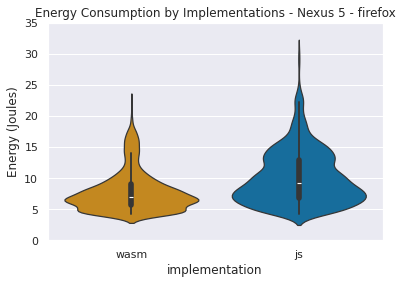

In [10]:
data = df
plt.ylim(0, 35)
vp = sns.violinplot(x='implementation', y='energy', hue='implementation', hue_order=implementations, data=data, palette='colorblind' ,dodge=False)
vp.set_title("Energy Consumption by Implementations - " + device + " - " + browser)
vp.set_ylabel("Energy (Joules)")
plt.show()

## Violinplot (By Browser)

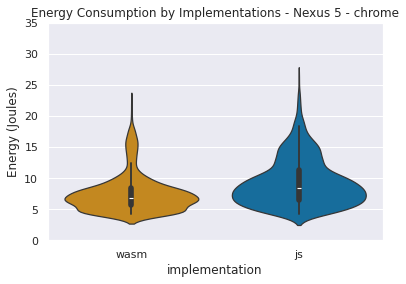

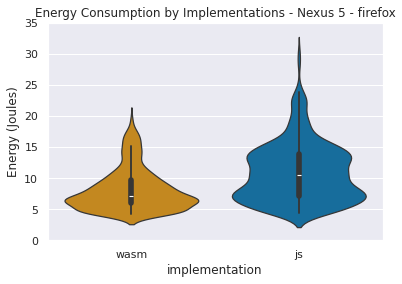

In [11]:
data = []
for browser in browsers:
    data = df[(df['browser'] == browser)]
    plt.ylim(0, 35)
    vp = sns.violinplot(x='implementation', y='energy', hue='implementation', hue_order=implementations, data=data, palette='colorblind' ,dodge=False)
    vp.set_title("Energy Consumption by Implementations - " + device + " - " + browser)
    vp.set_ylabel("Energy (Joules)")
    plt.show()

## Violinplot (By Browser & By Device)

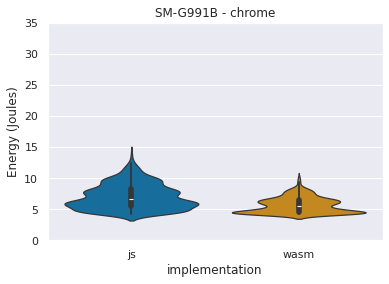

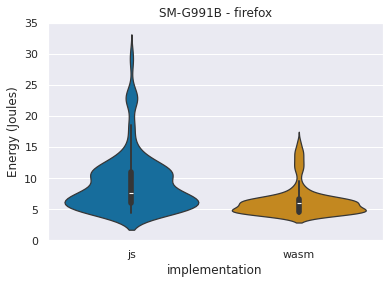

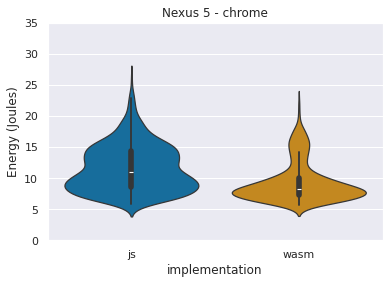

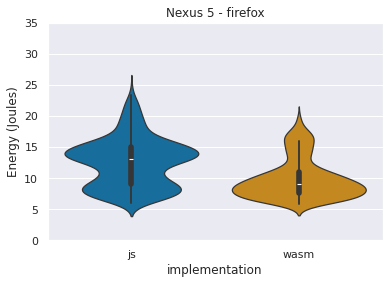

In [12]:
data = []
for device in devices:
    for browser in browsers:
        data = df[(df['browser'] == browser) & (df['device'] == device)].sort_values(by=['implementation'])
        plt.ylim(0, 35)
        vp = sns.violinplot(x='implementation', y='energy', hue='implementation', hue_order=implementations, data=data, palette='colorblind', dodge=False)
        vp.set_title(device + " - " + browser)
        vp.set_ylabel("Energy (Joules)")
        plt.show()

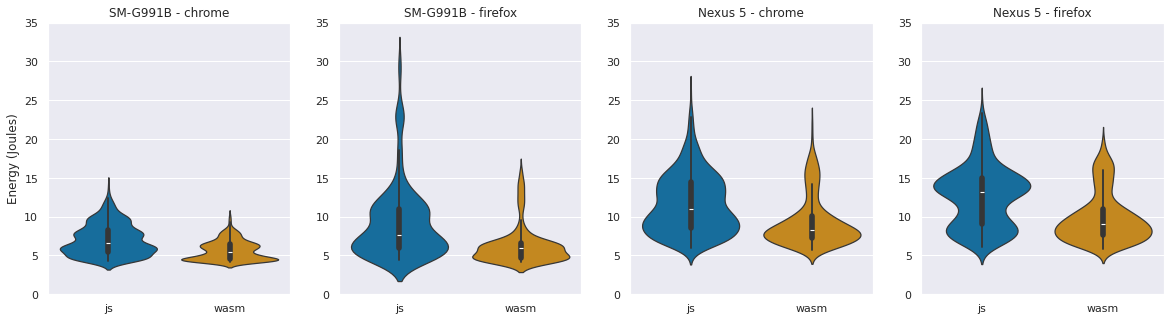

In [13]:
data = []
index=0
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

for device in devices:
    for browser in browsers:
        data = df[(df['browser'] == browser) & (df['device'] == device)].sort_values(by=['implementation'])
        vp = sns.violinplot(x='implementation', y='energy', hue='implementation', hue_order=implementations, data=data, palette='colorblind', dodge=False, ax=axes[index])
        vp.set_title(device + " - " + browser)
        axes[index].set_ylim(0, 35)
        axes[index].set_xlabel("")
        if index == 0:
            axes[0].set_ylabel("Energy (Joules)")
        else:
            axes[index].set_ylabel("")
        index+=1

## Violinplot (By Browser & Low End Device)

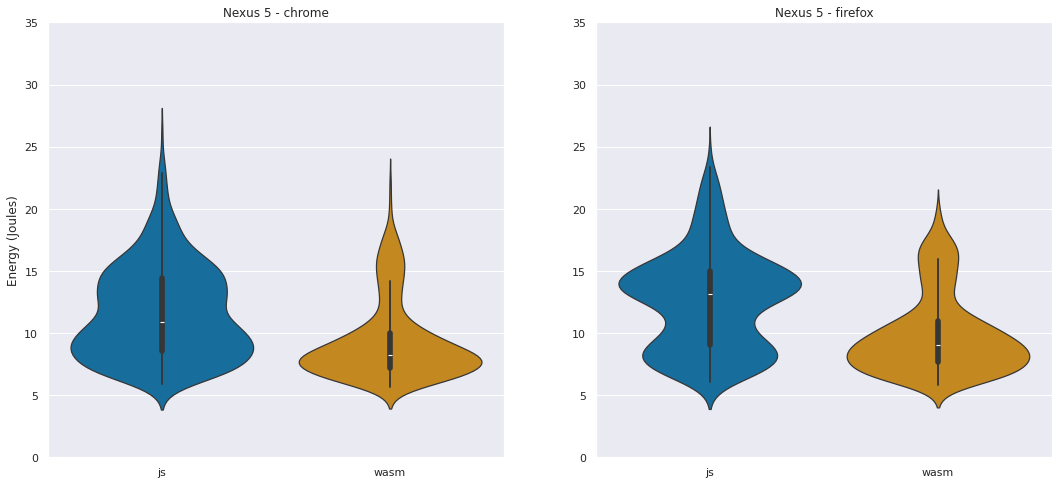

In [14]:
data = []

index=0
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
for browser in browsers:
    data = df[(df['browser'] == browser) & (df['device'] == 'Nexus 5')].sort_values(by=['implementation'])
    vp = sns.violinplot(x='implementation', y='energy', hue='implementation', hue_order=implementations, data=data, palette='colorblind', dodge=False, ax=axes[index])
    vp.set_title("Nexus 5 - " + browser)
    axes[index].set_ylim(0, 35)
    axes[index].set_xlabel("")
    if index == 0:
        axes[0].set_ylabel("Energy (Joules)")
    else:
        axes[index].set_ylabel("")
    index+=1

## Violinplot (By Browser & High End Device)

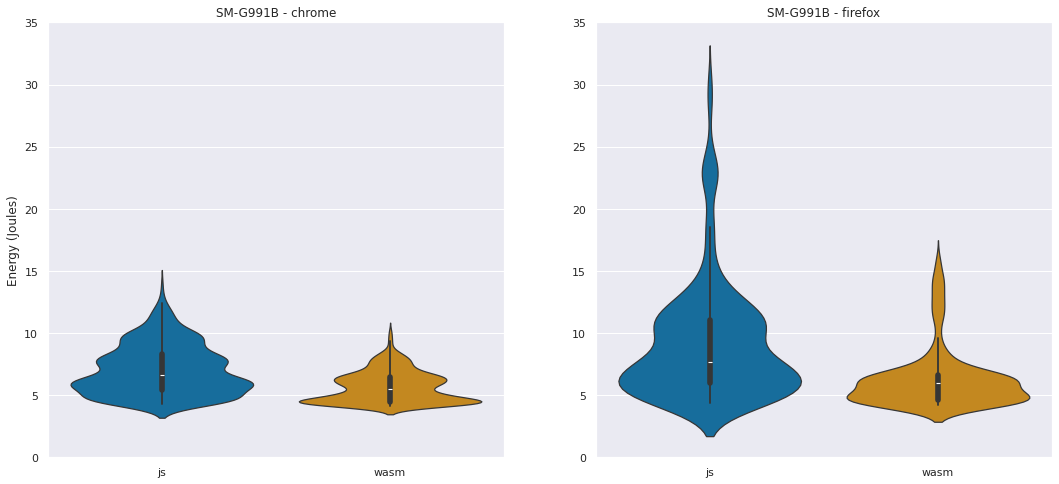

In [15]:
data = []

index=0
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
for browser in browsers:
    data = df[(df['browser'] == browser) & (df['device'] == 'SM-G991B')].sort_values(by=['implementation'])
    vp = sns.violinplot(x='implementation', y='energy', hue='implementation', hue_order=implementations, data=data, palette='colorblind', dodge=False, ax=axes[index])
    vp.set_title("SM-G991B - " + browser)
    axes[index].set_ylim(0, 35)
    axes[index].set_xlabel("")
    if index == 0:
        axes[0].set_ylabel("Energy (Joules)")
    else:
        axes[index].set_ylabel("")
    index+=1
        #plt.show()

## Violinplot (By Browser & Device Types)

In [16]:
## Prepare naming of values for final violinplot
df_violin = df.copy()
df_violin['implementation'] = df_violin['implementation'].replace(['wasm'], 'Wasm')
df_violin['implementation'] = df_violin['implementation'].replace(['js'], 'JS')
df_violin['browser'] = df_violin['browser'].replace(['chrome'], 'Chrome')
df_violin['browser'] = df_violin['browser'].replace(['firefox'], 'Firefox')
df_violin['device'] = df_violin['device'].replace(['SM-G991B'], 'Samsung Galaxy S21')
browsers_violin = numpy.sort(df_violin['browser'].unique())
devices_violin = numpy.sort(df_violin['device'].unique())

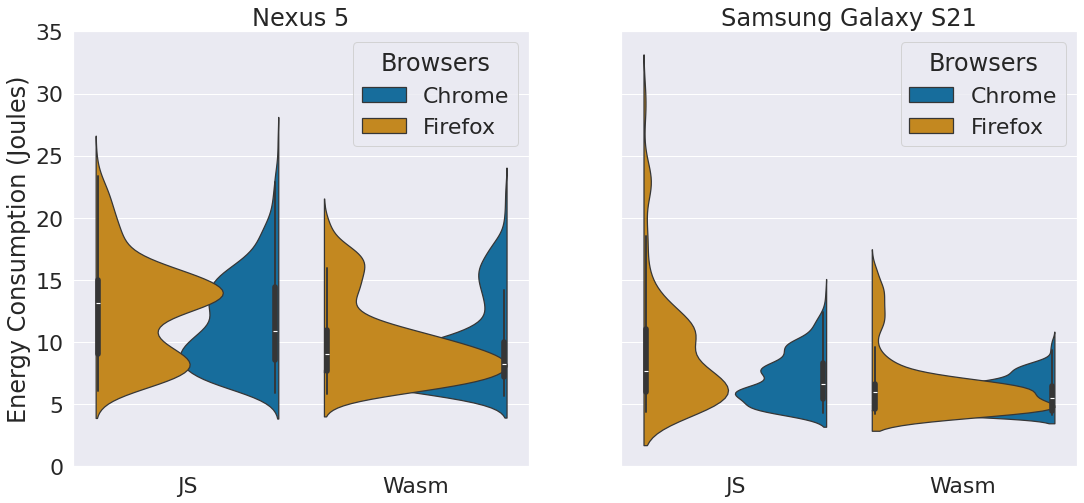

In [17]:
sns.set(font_scale=2)
data = []
index=0
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
for device in devices_violin:
    data = df_violin[(df_violin['device'] == device)].sort_values(by=['implementation'])
    vp = sns.violinplot(x='implementation', y='energy', hue='browser', hue_order=browsers_violin, data=data, palette='colorblind', dodge=False, ax=axes[index], split=True)
    vp.set_title(device)
    axes[index].legend(title="Browsers")
    axes[index].set_ylim(0, 35)
    axes[index].set_xlabel("")
    axes[index].set_ylabel("Energy Consumption (Joules)")
    if index == 0:
        axes[0].set_ylabel("Energy Consumption (Joules)")
    else:
        axes[index].set_ylabel("")
        axes[index].set_yticklabels([])
    index+=1

## Histogram

(0.0, 40.0)

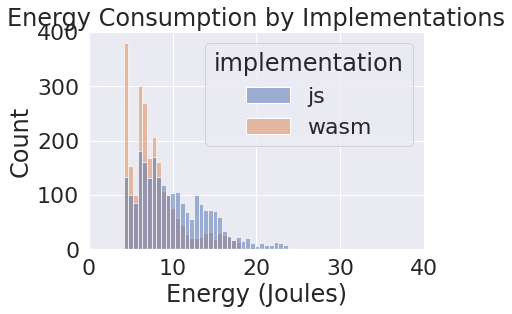

In [18]:
sns.histplot(data=df, x="energy", hue="implementation", hue_order=implementations).set_title("Energy Consumption by Implementations")
plt.xlabel("Energy (Joules)")
plt.ylim(0, 400)
plt.xlim(0, 40)

## Histogram (By Device)

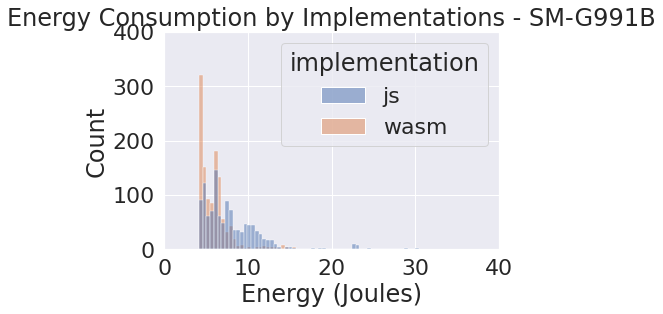

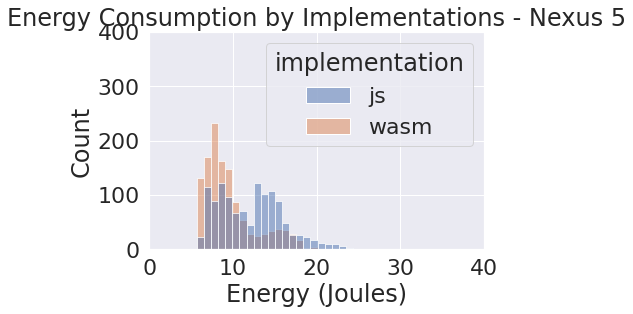

In [19]:
data = []
for device in devices:
    data = df[(df['device'] == device)]
    plt.xlabel("Energy (Joules)")
    plt.ylim(0, 400)
    plt.xlim(0, 40)
    sns.histplot(data=data, x="energy", hue="implementation", hue_order=implementations).set_title("Energy Consumption by Implementations - " + device)
    plt.show()

## Q-Q-Plot

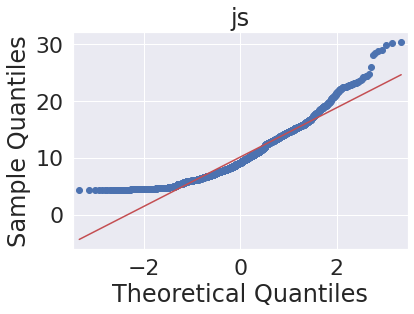

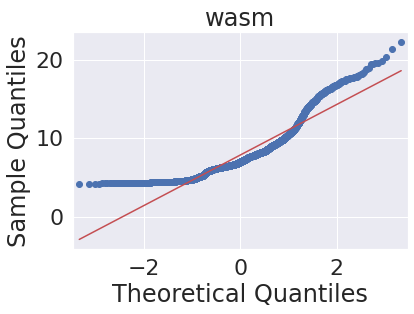

In [20]:
data = []
for implementation in implementations:
    data = df[(df['implementation'] == implementation)]
    qq = sm.qqplot(data.energy, line='s')
    h = plt.title(implementation)

## Q-Q-plot (By Device)

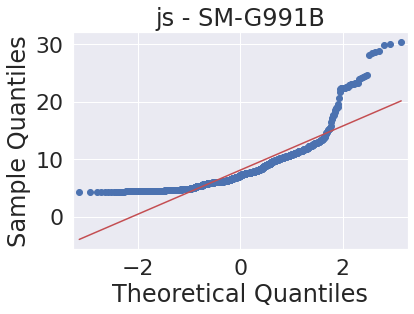

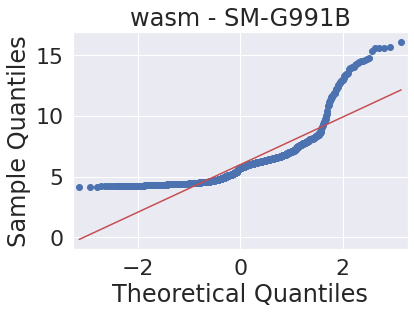

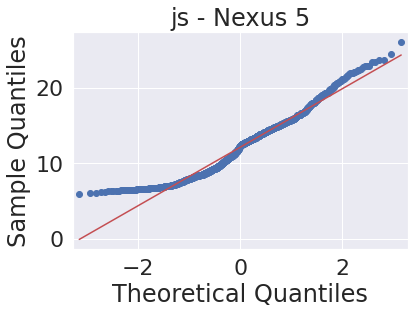

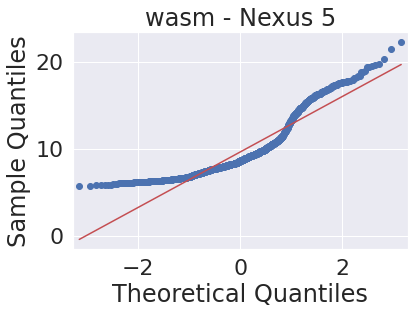

In [21]:
data = []
for device in devices:
    for implementation in implementations:
        data = df[(df['implementation'] == implementation) & (df['device'] == device)]
        qq = sm.qqplot(data.energy, line='s')
        h = plt.title(implementation + " - " + device)

## Mann Whitney U Test (same Browsers)

In [22]:
data = []

for browser in browsers:
    for implementationpair in implementationpairs:
        impl1_energy = df[(df['implementation'] == implementationpair[0]) & (df['browser'] == browser)]['energy']
        impl2_energy = df[(df['implementation'] == implementationpair[1]) & (df['browser'] == browser)]['energy']
        eff = cliff.cliffs_delta(impl1_energy, impl2_energy)

        u = stats.mannwhitneyu(impl1_energy, impl2_energy, alternative='two-sided')            

        data.append(
            [
             browser,
             implementationpair[0] + ' vs. ' + implementationpair[1],
             u.statistic,
             u.pvalue,
             eff[0],
             eff[1]
            ]
        )
        
# Create the pandas DataFrame
ut = pd.DataFrame(data, columns = ['browser', 'implementation', 'u', 'p', 'eff', 'interp'])
display(ut)

interp = ut['interp'].value_counts()
interp = pd.DataFrame(interp, columns = ['interp', 'percent'])
interp['percent'] = (interp['interp'] / interp['interp'].sum()) * 100

display(interp)

,browser,implementation,u,p,eff,interp
0,chrome,js vs. wasm,960697.0,1.168028e-41,0.317780,small
1,firefox,js vs. wasm,998597.0,5.082446e-57,0.374314,medium


,interp,percent


## Mann Whitney U Test (same Browsers - by Device)

In [23]:
data = []

for device in devices:
    for browser in browsers:
        for implementationpair in implementationpairs:
            impl1_energy = df[(df['implementation'] == implementationpair[0]) & (df['browser'] == browser) & (df['device'] == device)]['energy']
            impl2_energy = df[(df['implementation'] == implementationpair[1]) & (df['browser'] == browser) & (df['device'] == device)]['energy']
            eff = cliff.cliffs_delta(impl1_energy, impl2_energy)

            u = stats.mannwhitneyu(impl1_energy, impl2_energy, alternative='two-sided')            

            data.append(
                [
                 device,
                 browser,
                 implementationpair[0] + ' vs. ' + implementationpair[1],
                 u.statistic,
                 u.pvalue,
                 eff[0],
                 eff[1]
                ]
            )
        
# Create the pandas DataFrame
ut = pd.DataFrame(data, columns = ['device', 'browser', 'implementation', 'u', 'p', 'eff', 'interp'])
display(ut)

interp = ut['interp'].value_counts()
interp = pd.DataFrame(interp, columns = ['interp', 'percent'])
interp['percent'] = (interp['interp'] / interp['interp'].sum()) * 100

display(interp)

,device,browser,implementation,u,p,eff,interp
0,SM-G991B,chrome,js vs. wasm,250266.0,1.591990e-36,0.423401,medium
1,SM-G991B,firefox,js vs. wasm,256565.0,1.160505e-42,0.459227,medium
2,Nexus 5,chrome,js vs. wasm,263410.0,3.872448e-33,0.395187,medium
3,Nexus 5,firefox,js vs. wasm,261860.0,3.617754e-33,0.396013,medium


,interp,percent


## Mann Whitney U Test (Cross Browsers)

In [24]:
data = []

for pairswitch in [[0,1],[1,0]]:
    for implementationpair in implementationpairs:
        for browserpair in browserpairs:
            browser1_energy = df[(df['browser'] == browserpair[0]) & (df['implementation'] == implementationpair[pairswitch[0]])]['energy']
            browser2_energy = df[(df['browser'] == browserpair[1]) & (df['implementation'] == implementationpair[pairswitch[1]])]['energy']
            eff = cliff.cliffs_delta(browser1_energy, browser2_energy)

            u = stats.mannwhitneyu(browser1_energy, browser2_energy, alternative='two-sided')            

            data.append(
                [
                 browserpair[0] + ' vs. ' + browserpair[1],
                 implementationpair[pairswitch[0]] + ' vs. ' + implementationpair[pairswitch[1]],
                 u.statistic,
                 u.pvalue,
                 eff[0],
                 eff[1]
                ]
            )
        
# Create the pandas DataFrame
ut = pd.DataFrame(data, columns = ['browser', 'implementation', 'u', 'p', 'eff', 'interp'])
display(ut)

interp = ut['interp'].value_counts()
interp = pd.DataFrame(interp, columns = ['interp', 'percent'])
interp['percent'] = (interp['interp'] / interp['interp'].sum()) * 100

display(interp)

,browser,implementation,u,p,eff,interp
0,chrome vs. firefox,js vs. wasm,880131.0,3.841190e-19,0.210271,small
1,chrome vs. firefox,wasm vs. js,391450.0,3.216940e-86,-0.462606,medium


,interp,percent


## Mann Whitney U Test (Cross Browsers - By Device)

In [25]:
data = []

for device in devices:
    for pairswitch in [[0,1],[1,0]]:
        for implementationpair in implementationpairs:
            for browserpair in browserpairs:
                browser1_energy = df[(df['browser'] == browserpair[0]) & (df['implementation'] == implementationpair[pairswitch[0]]) & (df['device'] == device)]['energy']
                browser2_energy = df[(df['browser'] == browserpair[1]) & (df['implementation'] == implementationpair[pairswitch[1]]) & (df['device'] == device)]['energy']
                eff = cliff.cliffs_delta(browser1_energy, browser2_energy)

                u = stats.mannwhitneyu(browser1_energy, browser2_energy, alternative='two-sided')            

                data.append(
                    [
                     device,
                     browserpair[0] + ' vs. ' + browserpair[1],
                     implementationpair[pairswitch[0]] + ' vs. ' + implementationpair[pairswitch[1]],
                     u.statistic,
                     u.pvalue,
                     eff[0],
                     eff[1]
                    ]
                )
        
# Create the pandas DataFrame
ut = pd.DataFrame(data, columns = ['device', 'browser', 'implementation', 'u', 'p', 'eff', 'interp'])
display(ut)

interp = ut['interp'].value_counts()
interp = pd.DataFrame(interp, columns = ['interp', 'percent'])
interp['percent'] = (interp['interp'] / interp['interp'].sum()) * 100

display(interp)

,device,browser,implementation,u,p,eff,interp
0,SM-G991B,chrome vs. firefox,js vs. wasm,227749.0,1.136373e-17,0.286627,small
1,SM-G991B,chrome vs. firefox,wasm vs. js,74651.0,4.165707e-65,-0.572545,large
2,Nexus 5,chrome vs. firefox,js vs. wasm,239728.0,7.751432e-18,0.284300,small
3,Nexus 5,chrome vs. firefox,wasm vs. js,97397.0,1.789286e-49,-0.486644,large


,interp,percent


## Descriptive Statistics

In [26]:
data = []
for implementation in implementations:
    x = df[(df['implementation'] == implementation)]
    mean = numpy.round(numpy.mean(x['energy']), 2)
    median = numpy.round(numpy.median(x['energy']), 2)
    min = numpy.round(numpy.amin(x['energy']), 2)
    max = numpy.round(numpy.amax(x['energy']), 2)
    std = numpy.round(numpy.std(x['energy']), 2)
    sem = numpy.round(stats.sem(x['energy']), 2)
    q1 = numpy.round(numpy.quantile(x['energy'], 0.25), 2)
    q3 = numpy.round(numpy.quantile(x['energy'], 0.75), 2)
    
    data.append(
        [implementation, mean, std, min, q1, median, q3, max, sem]
    )
        
# Create the pandas DataFrame
stat = pd.DataFrame(data, columns = ['implementation', 'mean', 'std', 'min', 'q1', 'median', 'q3', 'max', 'sem'])
# display(stat)
print(stat.to_string())

# Alternative of pandas: x['energy'].describe()

  implementation   mean   std   min    q1  median     q3    max   sem
0             js  10.16  4.34  4.30  6.77    9.19  12.96  30.46  0.09
1           wasm   7.84  3.22  4.16  5.75    6.97   9.04  22.29  0.07


## Descriptive Statistics Difference

In [27]:
data = []

for implementationpair in implementationpairs:
    implementation1 = stat[(stat['implementation'] == implementationpair[1])]
    implementation2 = stat[(stat['implementation'] == implementationpair[0])]
    
    mean_diff = implementation1.iloc[0]['mean']-implementation2.iloc[0]['mean']
    median_diff = implementation1.iloc[0]['median']-implementation2.iloc[0]['median']
    min_diff = implementation1.iloc[0]['min']-implementation2.iloc[0]['min']
    max_diff = implementation1.iloc[0]['max']-implementation2.iloc[0]['max']
    std_diff = implementation1.iloc[0]['std']-implementation2.iloc[0]['std']
    sem_diff = implementation1.iloc[0]['sem']-implementation2.iloc[0]['sem']
    q1_diff = implementation1.iloc[0]['q1']-implementation2.iloc[0]['q1']
    q3_diff = implementation1.iloc[0]['q3']-implementation2.iloc[0]['q3']

    data.append(
        [implementationpair[1] + ' vs. ' + implementationpair[0],
         numpy.round(mean_diff, 2),
         numpy.round(mean_diff/implementation2.iloc[0]['mean']*100, 2),
         numpy.round(median_diff, 2),
         numpy.round(median_diff/implementation2.iloc[0]['median']*100, 2),
         numpy.round(min_diff, 2),
         numpy.round(min_diff/implementation2.iloc[0]['min']*100, 2),
         numpy.round(max_diff, 2),
         numpy.round(max_diff/implementation2.iloc[0]['max']*100, 2),
         numpy.round(std_diff, 2),
         numpy.round(std_diff/implementation2.iloc[0]['std']*100, 2),
         numpy.round(sem_diff, 2),
         numpy.round(sem_diff/implementation2.iloc[0]['sem']*100, 2),
         numpy.round(q1_diff, 2),
         numpy.round(q1_diff/implementation2.iloc[0]['q1']*100, 2),
         numpy.round(q3_diff, 2),
         numpy.round(q3_diff/implementation2.iloc[0]['q3']*100, 2),
        ]
    )
        
# Create the pandas DataFrame
ut = pd.DataFrame(data, columns = ['rq','mean_diff','mean_diff%','median_diff','median_diff%','min_diff','min_diff%','max_diff','max_diff%','std_diff','std_diff%','sem_diff','sem_diff%','q1_diff','q1_diff%','q3_diff','q3_diff%'])
display(ut)
#print(ut.to_string())

,rq,mean_diff,mean_diff%,median_diff,median_diff%,min_diff,min_diff%,max_diff,max_diff%,std_diff,std_diff%,sem_diff,sem_diff%,q1_diff,q1_diff%,q3_diff,q3_diff%
0,wasm vs. js,-2.32,-22.83,-2.22,-24.16,-0.14,-3.26,-8.17,-26.82,-1.12,-25.81,-0.02,-22.22,-1.02,-15.07,-3.92,-30.25


## Descriptive Statistics (By Browser)

In [28]:
data = []
for implementation in implementations:
    for browser in browsers:
        x = df[(df['implementation'] == implementation) & (df['browser'] == browser)]
        mean = numpy.round(numpy.mean(x['energy']), 2)
        median = numpy.round(numpy.median(x['energy']), 2)
        min = numpy.round(numpy.amin(x['energy']), 2)
        max = numpy.round(numpy.amax(x['energy']), 2)
        std = numpy.round(numpy.std(x['energy']), 2)
        sem = numpy.round(stats.sem(x['energy']), 2)
        q1 = numpy.round(numpy.quantile(x['energy'], 0.25), 2)
        q3 = numpy.round(numpy.quantile(x['energy'], 0.75), 2)

        data.append(
            [implementation, browser, mean, std, min, q1, median,  q3, max, sem]
        )
        
# Create the pandas DataFrame
stat = pd.DataFrame(data, columns = ['implementation', 'browser', 'mean', 'std', 'min', 'q1', 'median', 'q3', 'max', 'sem'])
# display(stat)
print(stat.to_string())

# Alternative of pandas: x['energy'].describe()

  implementation  browser   mean   std   min    q1  median     q3    max   sem
0             js   chrome   9.37  3.79  4.30  6.52    8.47  11.28  26.04  0.11
1             js  firefox  10.94  4.70  4.39  7.11   10.43  13.89  30.46  0.14
2           wasm   chrome   7.55  3.04  4.16  5.64    6.85   8.37  22.29  0.09
3           wasm  firefox   8.14  3.36  4.22  5.96    7.09   9.67  19.78  0.10


## Descriptive Statistics Difference (By Browser)

In [29]:
data = []

for implementationpair in implementationpairs:
    for browser in browsers:
        implementation1 = stat[(stat['implementation'] == implementationpair[1]) & (stat['browser'] == browser)]
        implementation2 = stat[(stat['implementation'] == implementationpair[0]) & (stat['browser'] == browser)]

        mean_diff = implementation1.iloc[0]['mean']-implementation2.iloc[0]['mean']
        median_diff = implementation1.iloc[0]['median']-implementation2.iloc[0]['median']
        min_diff = implementation1.iloc[0]['min']-implementation2.iloc[0]['min']
        max_diff = implementation1.iloc[0]['max']-implementation2.iloc[0]['max']
        std_diff = implementation1.iloc[0]['std']-implementation2.iloc[0]['std']
        sem_diff = implementation1.iloc[0]['sem']-implementation2.iloc[0]['sem']
        q1_diff = implementation1.iloc[0]['q1']-implementation2.iloc[0]['q1']
        q3_diff = implementation1.iloc[0]['q3']-implementation2.iloc[0]['q3']

        data.append(
            [implementationpair[1] + ' vs. ' + implementationpair[0] + ' ' + browser,
             numpy.round(mean_diff, 2),
             numpy.round(mean_diff/implementation2.iloc[0]['mean']*100, 2),
             numpy.round(median_diff, 2),
             numpy.round(median_diff/implementation2.iloc[0]['median']*100, 2),
             numpy.round(min_diff, 2),
             numpy.round(min_diff/implementation2.iloc[0]['min']*100, 2),
             numpy.round(max_diff, 2),
             numpy.round(max_diff/implementation2.iloc[0]['max']*100, 2),
             numpy.round(std_diff, 2),
             numpy.round(std_diff/implementation2.iloc[0]['std']*100, 2),
             numpy.round(sem_diff, 2),
             numpy.round(sem_diff/implementation2.iloc[0]['sem']*100, 2),
             numpy.round(q1_diff, 2),
             numpy.round(q1_diff/implementation2.iloc[0]['q1']*100, 2),
             numpy.round(q3_diff, 2),
             numpy.round(q3_diff/implementation2.iloc[0]['q3']*100, 2),
            ]
        )
        
# Create the pandas DataFrame
ut = pd.DataFrame(data, columns = ['rq','mean_diff','mean_diff%','median_diff','median_diff%','min_diff','min_diff%','max_diff','max_diff%','std_diff','std_diff%','sem_diff','sem_diff%','q1_diff','q1_diff%','q3_diff','q3_diff%'])
display(ut)
#print(ut.to_string())

,rq,mean_diff,mean_diff%,median_diff,median_diff%,min_diff,min_diff%,max_diff,max_diff%,std_diff,std_diff%,sem_diff,sem_diff%,q1_diff,q1_diff%,q3_diff,q3_diff%
0,wasm vs. js chrome,-1.82,-19.42,-1.62,-19.13,-0.14,-3.26,-3.75,-14.40,-0.75,-19.79,-0.02,-18.18,-0.88,-13.50,-2.91,-25.80
1,wasm vs. js firefox,-2.80,-25.59,-3.34,-32.02,-0.17,-3.87,-10.68,-35.06,-1.34,-28.51,-0.04,-28.57,-1.15,-16.17,-4.22,-30.38


## Descriptive Statistics Difference (Cross Browser)

In [30]:
data = []

for pairswitch in [[0,1],[1,0]]:
    for implementationpair in implementationpairs:
        for browserpair in browserpairs:
            implementation1 = stat[(stat['browser'] == browserpair[pairswitch[1]]) & (stat['implementation'] == implementationpair[1])]
            implementation2 = stat[(stat['browser'] == browserpair[pairswitch[0]]) & (stat['implementation'] == implementationpair[0])]

#for implementationpair in implementationpairs:
#    for browser in browsers:
#        implementation1 = stat[(stat['implementation'] == implementationpair[0]) & (stat['browser'] == browser)]
#        implementation2 = stat[(stat['implementation'] == implementationpair[1]) & (stat['browser'] == browser)]

        mean_diff = implementation1.iloc[0]['mean']-implementation2.iloc[0]['mean']
        median_diff = implementation1.iloc[0]['median']-implementation2.iloc[0]['median']
        min_diff = implementation1.iloc[0]['min']-implementation2.iloc[0]['min']
        max_diff = implementation1.iloc[0]['max']-implementation2.iloc[0]['max']
        std_diff = implementation1.iloc[0]['std']-implementation2.iloc[0]['std']
        sem_diff = implementation1.iloc[0]['sem']-implementation2.iloc[0]['sem']
        q1_diff = implementation1.iloc[0]['q1']-implementation2.iloc[0]['q1']
        q3_diff = implementation1.iloc[0]['q3']-implementation2.iloc[0]['q3']

        data.append(
            [
             browserpair[pairswitch[1]] + ' ' + implementationpair[1] + ' vs. ' + browserpair[pairswitch[0]] + ' ' + implementationpair[0],
             numpy.round(mean_diff, 2),
             numpy.round(mean_diff/implementation2.iloc[0]['mean']*100, 2),
             numpy.round(median_diff, 2),
             numpy.round(median_diff/implementation2.iloc[0]['median']*100, 2),
             numpy.round(min_diff, 2),
             numpy.round(min_diff/implementation2.iloc[0]['min']*100, 2),
             numpy.round(max_diff, 2),
             numpy.round(max_diff/implementation2.iloc[0]['max']*100, 2),
             numpy.round(std_diff, 2),
             numpy.round(std_diff/implementation2.iloc[0]['std']*100, 2),
             numpy.round(sem_diff, 2),
             numpy.round(sem_diff/implementation2.iloc[0]['sem']*100, 2),
             numpy.round(q1_diff, 2),
             numpy.round(q1_diff/implementation2.iloc[0]['q1']*100, 2),
             numpy.round(q3_diff, 2),
             numpy.round(q3_diff/implementation2.iloc[0]['q3']*100, 2),
            ]
        )
        
# Create the pandas DataFrame
ut = pd.DataFrame(data, columns = ['rq','mean_diff','mean_diff%','median_diff','median_diff%','min_diff','min_diff%','max_diff','max_diff%','std_diff','std_diff%','sem_diff','sem_diff%','q1_diff','q1_diff%','q3_diff','q3_diff%'])
display(ut)
#print(ut.to_string())

,rq,mean_diff,mean_diff%,median_diff,median_diff%,min_diff,min_diff%,max_diff,max_diff%,std_diff,std_diff%,sem_diff,sem_diff%,q1_diff,q1_diff%,q3_diff,q3_diff%
0,firefox wasm vs. chrome js,-1.23,-13.13,-1.38,-16.29,-0.08,-1.86,-6.26,-24.04,-0.43,-11.35,-0.01,-9.09,-0.56,-8.59,-1.61,-14.27
1,chrome wasm vs. firefox js,-3.39,-30.99,-3.58,-34.32,-0.23,-5.24,-8.17,-26.82,-1.66,-35.32,-0.05,-35.71,-1.47,-20.68,-5.52,-39.74


## Descriptive Statistics (By Browser & By Device)

In [31]:
data = []
for device in devices:
    for implementation in implementations:
        for browser in browsers:
            x = df[(df['implementation'] == implementation) & (df['browser'] == browser) & (df['device'] == device)]
            mean = numpy.round(numpy.mean(x['energy']), 2)
            median = numpy.round(numpy.median(x['energy']), 2)
            min = numpy.round(numpy.amin(x['energy']), 2)
            max = numpy.round(numpy.amax(x['energy']), 2)
            std = numpy.round(numpy.std(x['energy']), 2)
            sem = numpy.round(stats.sem(x['energy']), 2)
            q1 = numpy.round(numpy.quantile(x['energy'], 0.25), 2)
            q3 = numpy.round(numpy.quantile(x['energy'], 0.75), 2)

            data.append(
                [implementation, device, browser, mean, std, min, q1, median, q3, max, sem]
            )
        
# Create the pandas DataFrame
stat = pd.DataFrame(data, columns = ['implementation', 'device', 'browser', 'mean', 'std', 'min', 'q1', 'median', 'q3', 'max', 'sem'])
# display(stat)
print(stat.to_string())

# Alternative of pandas: x['energy'].describe()

  implementation    device  browser   mean   std   min    q1  median     q3    max   sem
0             js  SM-G991B   chrome   7.05  2.00  4.30  5.46    6.62   8.29  13.96  0.08
1             js  SM-G991B  firefox   9.21  4.82  4.39  5.99    7.67  11.03  30.46  0.20
2           wasm  SM-G991B   chrome   5.67  1.25  4.16  4.49    5.47   6.46  10.14  0.05
3           wasm  SM-G991B  firefox   6.32  2.43  4.22  4.63    5.96   6.62  16.11  0.10
4             js   Nexus 5   chrome  11.64  3.75  5.92  8.53   10.93  14.44  26.04  0.15
5             js   Nexus 5  firefox  12.61  3.91  6.06  9.03   13.13  15.01  24.44  0.16
6           wasm   Nexus 5   chrome   9.34  3.16  5.67  7.23    8.24  10.02  22.29  0.13
7           wasm   Nexus 5  firefox   9.91  3.19  5.79  7.63    9.04  10.99  19.78  0.13


## Descriptive Statistics Difference (By Browser & By Device)

In [32]:
data = []

for implementationpair in implementationpairs:
    for device in devices:
        for browser in browsers:
            implementation1 = stat[(stat['implementation'] == implementationpair[1]) & (stat['browser'] == browser) & (stat['device'] == device)]
            implementation2 = stat[(stat['implementation'] == implementationpair[0]) & (stat['browser'] == browser) & (stat['device'] == device)]

            mean_diff = implementation1.iloc[0]['mean']-implementation2.iloc[0]['mean']
            median_diff = implementation1.iloc[0]['median']-implementation2.iloc[0]['median']
            min_diff = implementation1.iloc[0]['min']-implementation2.iloc[0]['min']
            max_diff = implementation1.iloc[0]['max']-implementation2.iloc[0]['max']
            std_diff = implementation1.iloc[0]['std']-implementation2.iloc[0]['std']
            sem_diff = implementation1.iloc[0]['sem']-implementation2.iloc[0]['sem']
            q1_diff = implementation1.iloc[0]['q1']-implementation2.iloc[0]['q1']
            q3_diff = implementation1.iloc[0]['q3']-implementation2.iloc[0]['q3']

            data.append(
                [implementationpair[1] + ' vs. ' + implementationpair[0] + ' ' + browser,
                 device,
                 numpy.round(mean_diff, 2),
                 numpy.round(mean_diff/implementation2.iloc[0]['mean']*100, 2),
                 numpy.round(median_diff, 2),
                 numpy.round(median_diff/implementation2.iloc[0]['median']*100, 2),
                 numpy.round(min_diff, 2),
                 numpy.round(min_diff/implementation2.iloc[0]['min']*100, 2),
                 numpy.round(max_diff, 2),
                 numpy.round(max_diff/implementation2.iloc[0]['max']*100, 2),
                 numpy.round(std_diff, 2),
                 numpy.round(std_diff/implementation2.iloc[0]['std']*100, 2),
                 numpy.round(sem_diff, 2),
                 numpy.round(sem_diff/implementation2.iloc[0]['sem']*100, 2),
                 numpy.round(q1_diff, 2),
                 numpy.round(q1_diff/implementation2.iloc[0]['q1']*100, 2),
                 numpy.round(q3_diff, 2),
                 numpy.round(q3_diff/implementation2.iloc[0]['q3']*100, 2),
                ]
            )
        
# Create the pandas DataFrame
ut = pd.DataFrame(data, columns = ['rq','device','mean_diff','mean_diff%','median_diff','median_diff%','min_diff','min_diff%','max_diff','max_diff%','std_diff','std_diff%','sem_diff','sem_diff%','q1_diff','q1_diff%','q3_diff','q3_diff%'])
display(ut)
#print(ut.to_string())

,rq,device,mean_diff,mean_diff%,median_diff,median_diff%,min_diff,min_diff%,max_diff,max_diff%,std_diff,std_diff%,sem_diff,sem_diff%,q1_diff,q1_diff%,q3_diff,q3_diff%
0,wasm vs. js chrome,SM-G991B,-1.38,-19.57,-1.15,-17.37,-0.14,-3.26,-3.82,-27.36,-0.75,-37.50,-0.03,-37.50,-0.97,-17.77,-1.83,-22.07
1,wasm vs. js firefox,SM-G991B,-2.89,-31.38,-1.71,-22.29,-0.17,-3.87,-14.35,-47.11,-2.39,-49.59,-0.10,-50.00,-1.36,-22.70,-4.41,-39.98
2,wasm vs. js chrome,Nexus 5,-2.30,-19.76,-2.69,-24.61,-0.25,-4.22,-3.75,-14.40,-0.59,-15.73,-0.02,-13.33,-1.30,-15.24,-4.42,-30.61
3,wasm vs. js firefox,Nexus 5,-2.70,-21.41,-4.09,-31.15,-0.27,-4.46,-4.66,-19.07,-0.72,-18.41,-0.03,-18.75,-1.40,-15.50,-4.02,-26.78


## Descriptive Statistics Difference (Cross Browser & By Device)

In [33]:
data = []

for pairswitch in [[0,1],[1,0]]:
    for device in devices:
        for implementationpair in implementationpairs:
            for browserpair in browserpairs:
                implementation1 = stat[(stat['browser'] == browserpair[pairswitch[1]]) & (stat['implementation'] == implementationpair[1]) & (stat['device'] == device)]
                implementation2 = stat[(stat['browser'] == browserpair[pairswitch[0]]) & (stat['implementation'] == implementationpair[0]) & (stat['device'] == device)]

    #for implementationpair in implementationpairs:
    #    for browser in browsers:
    #        implementation1 = stat[(stat['implementation'] == implementationpair[0]) & (stat['browser'] == browser)]
    #        implementation2 = stat[(stat['implementation'] == implementationpair[1]) & (stat['browser'] == browser)]

            mean_diff = implementation1.iloc[0]['mean']-implementation2.iloc[0]['mean']
            median_diff = implementation1.iloc[0]['median']-implementation2.iloc[0]['median']
            min_diff = implementation1.iloc[0]['min']-implementation2.iloc[0]['min']
            max_diff = implementation1.iloc[0]['max']-implementation2.iloc[0]['max']
            std_diff = implementation1.iloc[0]['std']-implementation2.iloc[0]['std']
            sem_diff = implementation1.iloc[0]['sem']-implementation2.iloc[0]['sem']
            q1_diff = implementation1.iloc[0]['q1']-implementation2.iloc[0]['q1']
            q3_diff = implementation1.iloc[0]['q3']-implementation2.iloc[0]['q3']

            data.append(
                [
                 browserpair[pairswitch[1]] + ' ' + implementationpair[1] + ' vs. ' + browserpair[pairswitch[0]] + ' ' + implementationpair[0],
                 device,
                 numpy.round(mean_diff, 2),
                 numpy.round(mean_diff/implementation2.iloc[0]['mean']*100, 2),
                 numpy.round(median_diff, 2),
                 numpy.round(median_diff/implementation2.iloc[0]['median']*100, 2),
                 numpy.round(min_diff, 2),
                 numpy.round(min_diff/implementation2.iloc[0]['min']*100, 2),
                 numpy.round(max_diff, 2),
                 numpy.round(max_diff/implementation2.iloc[0]['max']*100, 2),
                 numpy.round(std_diff, 2),
                 numpy.round(std_diff/implementation2.iloc[0]['std']*100, 2),
                 numpy.round(sem_diff, 2),
                 numpy.round(sem_diff/implementation2.iloc[0]['sem']*100, 2),
                 numpy.round(q1_diff, 2),
                 numpy.round(q1_diff/implementation2.iloc[0]['q1']*100, 2),
                 numpy.round(q3_diff, 2),
                 numpy.round(q3_diff/implementation2.iloc[0]['q3']*100, 2),
                ]
            )
        
# Create the pandas DataFrame
ut = pd.DataFrame(data, columns = ['rq','device','mean_diff','mean_diff%','median_diff','median_diff%','min_diff','min_diff%','max_diff','max_diff%','std_diff','std_diff%','sem_diff','sem_diff%','q1_diff','q1_diff%','q3_diff','q3_diff%'])
display(ut)
#print(ut.to_string())

,rq,device,mean_diff,mean_diff%,median_diff,median_diff%,min_diff,min_diff%,max_diff,max_diff%,std_diff,std_diff%,sem_diff,sem_diff%,q1_diff,q1_diff%,q3_diff,q3_diff%
0,firefox wasm vs. chrome js,SM-G991B,-0.73,-10.35,-0.66,-9.97,-0.08,-1.86,2.15,15.40,0.43,21.50,0.02,25.00,-0.83,-15.20,-1.67,-20.14
1,firefox wasm vs. chrome js,Nexus 5,-1.73,-14.86,-1.89,-17.29,-0.13,-2.20,-6.26,-24.04,-0.56,-14.93,-0.02,-13.33,-0.90,-10.55,-3.45,-23.89
2,chrome wasm vs. firefox js,SM-G991B,-3.54,-38.44,-2.20,-28.68,-0.23,-5.24,-20.32,-66.71,-3.57,-74.07,-0.15,-75.00,-1.50,-25.04,-4.57,-41.43
3,chrome wasm vs. firefox js,Nexus 5,-3.27,-25.93,-4.89,-37.24,-0.39,-6.44,-2.15,-8.80,-0.75,-19.18,-0.03,-18.75,-1.80,-19.93,-4.99,-33.24


# RQ2: JS Energy Browser <a name="rq2js"></a>

## Shapiro Wilk Test

In [34]:
data = []
non_normal = 0

for browser in browsers:
    energy = df[(df['browser'] == browser) & (df['implementation'] == 'js')]['energy']

    if len(energy) >= 3:
        shapiro_test = stats.shapiro(energy)

        non_normal += (1 if shapiro_test.pvalue <= 0.05 else 0)

        data.append(
            [browser, 'js',
             shapiro_test.statistic,
             shapiro_test.pvalue
            ]
        )
        
# Create the pandas DataFrame
swt = pd.DataFrame(data, columns = ['browser', 'implementation', 'w', 'p'])
#print(swt.to_string())
display(swt)

print("\n{} non-normally distributed samples".format(non_normal))
print("{} normally distributed samples".format(len(swt) - non_normal))
print("{:.2f}% non-normally distributed samples".format(non_normal/len(swt)*100)) 

,browser,implementation,w,p
0,chrome,js,0.923120,2.485691e-24
1,firefox,js,0.939191,8.412692e-22



2 non-normally distributed samples
0 normally distributed samples
100.00% non-normally distributed samples


## Shapiro Wilk Test (By Device)

In [35]:
data = []
non_normal = 0

for device in devices:
    for browser in browsers:
        energy = df[(df['browser'] == browser) & (df['implementation'] == 'js') & (df['device'] == device)]['energy']

        if len(energy) >= 3:
            shapiro_test = stats.shapiro(energy)

            non_normal += (1 if shapiro_test.pvalue <= 0.05 else 0)

            data.append(
                [
                 device,
                 browser, 'js',
                 shapiro_test.statistic,
                 shapiro_test.pvalue
                ]
            )
        
# Create the pandas DataFrame
swt = pd.DataFrame(data, columns = ['device', 'browser', 'implementation', 'w', 'p'])
#print(swt.to_string())
display(swt)

print("\n{} non-normally distributed samples".format(non_normal))
print("{} normally distributed samples".format(len(swt) - non_normal))
print("{:.2f}% non-normally distributed samples".format(non_normal/len(swt)*100)) 

,device,browser,implementation,w,p
0,SM-G991B,chrome,js,0.943418,2.788160e-14
1,SM-G991B,firefox,js,0.808114,6.720060e-26
2,Nexus 5,chrome,js,0.949549,1.371225e-13
3,Nexus 5,firefox,js,0.963830,3.718362e-11



4 non-normally distributed samples
0 normally distributed samples
100.00% non-normally distributed samples


## Mann Whitney U Test

In [36]:
data = []

for browserpair in browserpairs:
    browser1_energy = df[(df['browser'] == browserpair[0]) & (df['implementation'] == 'js')]['energy']
    browser2_energy = df[(df['browser'] == browserpair[1]) & (df['implementation'] == 'js')]['energy']
    eff = cliff.cliffs_delta(browser1_energy, browser2_energy)

    u = stats.mannwhitneyu(browser1_energy, browser2_energy, alternative='two-sided')            

    data.append(
        [
         browserpair[0] + ' vs. ' + browserpair[1],
         u.statistic,
         u.pvalue,
         eff[0],
         eff[1]
        ]
    )
        
# Create the pandas DataFrame
ut = pd.DataFrame(data, columns = ['rq', 'u', 'p', 'eff', 'interp'])
display(ut)

interp = ut['interp'].value_counts()
interp = pd.DataFrame(interp, columns = ['interp', 'percent'])
interp['percent'] = (interp['interp'] / interp['interp'].sum()) * 100

display(interp)

,rq,u,p,eff,interp
0,chrome vs. firefox,586526.0,2.471443e-16,-0.192797,small


,interp,percent


## Mann Whitney U Test (By Device)

In [37]:
data = []

for device in devices:
    for browserpair in browserpairs:
        browser1_energy = df[(df['browser'] == browserpair[0]) & (df['implementation'] == 'js') & (df['device'] == device)]['energy']
        browser2_energy = df[(df['browser'] == browserpair[1]) & (df['implementation'] == 'js') & (df['device'] == device)]['energy']
        eff = cliff.cliffs_delta(browser1_energy, browser2_energy)

        u = stats.mannwhitneyu(browser1_energy, browser2_energy, alternative='two-sided')            

        data.append(
            [
             device,
             browserpair[0] + ' vs. ' + browserpair[1],
             u.statistic,
             u.pvalue,
             eff[0],
             eff[1]
            ]
        )
        
# Create the pandas DataFrame
ut = pd.DataFrame(data, columns = ['device', 'rq', 'u', 'p', 'eff', 'interp'])
display(ut)

interp = ut['interp'].value_counts()
interp = pd.DataFrame(interp, columns = ['interp', 'percent'])
interp['percent'] = (interp['interp'] / interp['interp'].sum()) * 100

display(interp)

,device,rq,u,p,eff,interp
0,SM-G991B,chrome vs. firefox,130114.0,9.184663e-15,-0.259970,small
1,Nexus 5,chrome vs. firefox,160175.0,9.598055e-06,-0.146084,negligible


,interp,percent


## Q-Q-Plot

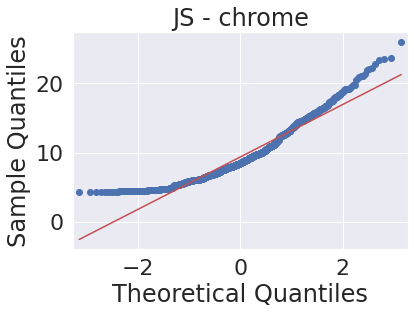

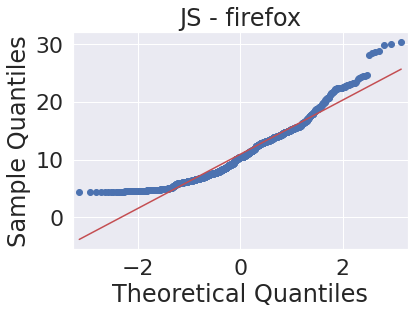

In [38]:
for browser in browsers:
    data = df[(df['implementation'] == 'js') & (df['browser'] == browser)]
    qq = sm.qqplot(data.energy, line='s')
    h = plt.title('JS - ' + browser)

## Q-Q-Plot (By Device)

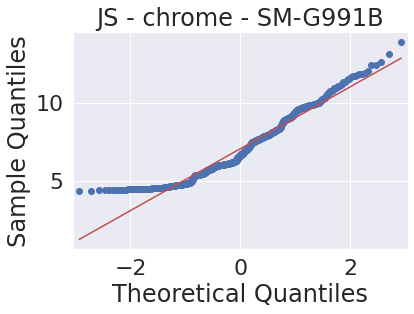

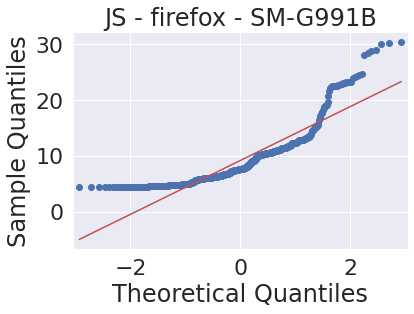

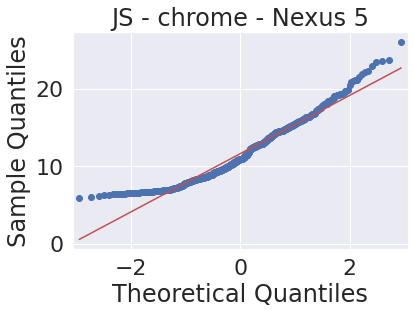

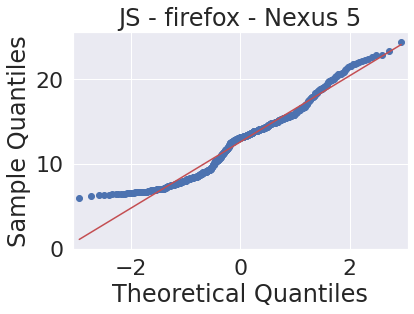

In [39]:
for device in devices:
    for browser in browsers:
        data = df[(df['implementation'] == 'js') & (df['browser'] == browser) & (df['device'] == device)]
        qq = sm.qqplot(data.energy, line='s')
        h = plt.title('JS - ' + browser + ' - ' + device)

## Histogram

(0.0, 35.0)

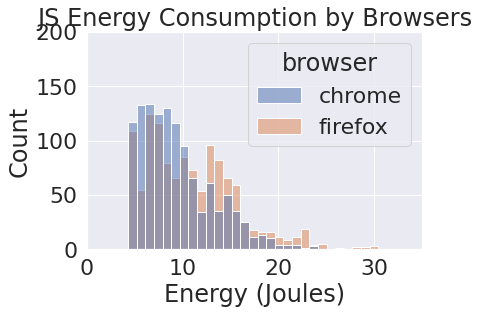

In [40]:
data = df[(df['implementation'] == 'js')]
sns.histplot(data=data, x="energy", hue="browser", hue_order=browsers).set_title("JS Energy Consumption by Browsers")
plt.xlabel("Energy (Joules)")
plt.ylim(0, 200)
plt.xlim(0, 35)

## Histogramm (By Device)

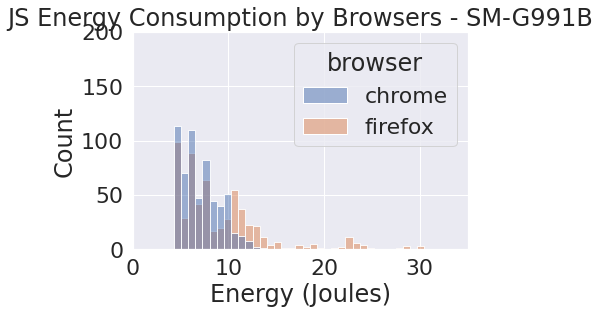

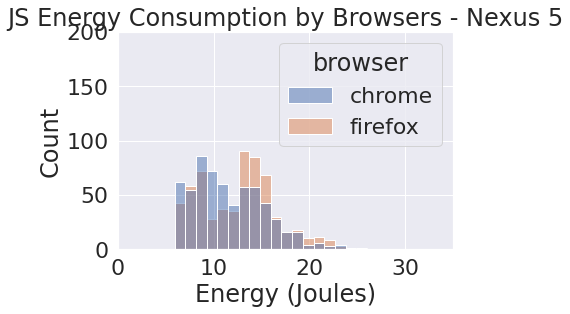

In [41]:
data = []
for device in devices:
    data = df[(df['implementation'] == 'js') & (df['device'] == device)]
    sns.histplot(data=data, x="energy", hue="browser", hue_order=browsers).set_title("JS Energy Consumption by Browsers" + " - " + device)
    plt.xlabel("Energy (Joules)")
    plt.ylim(0, 200)
    plt.xlim(0, 35)
    plt.show()

## Descriptive Statistics

In [42]:
data = []
for browser in browsers:
    x = df[(df['browser'] == browser) & (df['implementation'] == 'js')]
    mean = numpy.round(numpy.mean(x['energy']), 2)
    median = numpy.round(numpy.median(x['energy']), 2)
    min = numpy.round(numpy.amin(x['energy']), 2)
    max = numpy.round(numpy.amax(x['energy']), 2)
    std = numpy.round(numpy.std(x['energy']), 2)
    sem = numpy.round(stats.sem(x['energy']), 2)
    q1 = numpy.round(numpy.quantile(x['energy'], 0.25), 2)
    q3 = numpy.round(numpy.quantile(x['energy'], 0.75), 2)
    
    data.append(
        [browser, mean, std, min, q1, median, q3, max, sem]
    )
        
# Create the pandas DataFrame
stat = pd.DataFrame(data, columns = ['browser', 'mean', 'std', 'min', 'q1', 'median', 'q3', 'max', 'sem'])
display(stat)
#print(stat.to_string())

# Alternative of pandas: x['energy'].describe()

,browser,mean,std,min,q1,median,q3,max,sem
0,chrome,9.37,3.79,4.30,6.52,8.47,11.28,26.04,0.11
1,firefox,10.94,4.70,4.39,7.11,10.43,13.89,30.46,0.14


## Descriptive Statistics Difference

In [43]:
data = []

for browserpair in browserpairs:
    browser1 = stat[(stat['browser'] == browserpair[0])]
    browser2 = stat[(stat['browser'] == browserpair[1])]
    
    mean_diff = browser1.iloc[0]['mean']-browser2.iloc[0]['mean']
    median_diff = browser1.iloc[0]['median']-browser2.iloc[0]['median']
    min_diff = browser1.iloc[0]['min']-browser2.iloc[0]['min']
    max_diff = browser1.iloc[0]['max']-browser2.iloc[0]['max']
    std_diff = browser1.iloc[0]['std']-browser2.iloc[0]['std']
    sem_diff = browser1.iloc[0]['sem']-browser2.iloc[0]['sem']
    q1_diff = browser1.iloc[0]['q1']-browser2.iloc[0]['q1']
    q3_diff = browser1.iloc[0]['q3']-browser2.iloc[0]['q3']

    data.append(
        [browserpair[0] + ' vs. ' + browserpair[1],
         numpy.round(mean_diff, 2),
         numpy.round(mean_diff/browser2.iloc[0]['mean']*100, 2),
         numpy.round(median_diff, 2),
         numpy.round(median_diff/browser2.iloc[0]['median']*100, 2),
         numpy.round(min_diff, 2),
         numpy.round(min_diff/browser2.iloc[0]['min']*100, 2),
         numpy.round(max_diff, 2),
         numpy.round(max_diff/browser2.iloc[0]['max']*100, 2),
         numpy.round(std_diff, 2),
         numpy.round(std_diff/browser2.iloc[0]['std']*100, 2),
         numpy.round(sem_diff, 2),
         numpy.round(sem_diff/browser2.iloc[0]['sem']*100, 2),
         numpy.round(q1_diff, 2),
         numpy.round(q1_diff/browser2.iloc[0]['q1']*100, 2),
         numpy.round(q3_diff, 2),
         numpy.round(q3_diff/browser2.iloc[0]['q3']*100, 2),
        ]
    )
        
# Create the pandas DataFrame
ut = pd.DataFrame(data, columns = ['rq','mean_diff','mean_diff%','median_diff','median_diff%','min_diff','min_diff%','max_diff','max_diff%','std_diff','std_diff%','sem_diff','sem_diff%','q1_diff','q1_diff%','q3_diff','q3_diff%'])
display(ut)
#print(ut.to_string())

,rq,mean_diff,mean_diff%,median_diff,median_diff%,min_diff,min_diff%,max_diff,max_diff%,std_diff,std_diff%,sem_diff,sem_diff%,q1_diff,q1_diff%,q3_diff,q3_diff%
0,chrome vs. firefox,-1.57,-14.35,-1.96,-18.79,-0.09,-2.05,-4.42,-14.51,-0.91,-19.36,-0.03,-21.43,-0.59,-8.3,-2.61,-18.79


## Descriptive Statistics (By Device)

In [44]:
data = []
for device in devices:
    for browser in browsers:
        x = df[(df['browser'] == browser) & (df['implementation'] == 'js') & (df['device'] == device)]
        mean = numpy.round(numpy.mean(x['energy']), 2)
        median = numpy.round(numpy.median(x['energy']), 2)
        min = numpy.round(numpy.amin(x['energy']), 2)
        max = numpy.round(numpy.amax(x['energy']), 2)
        std = numpy.round(numpy.std(x['energy']), 2)
        sem = numpy.round(stats.sem(x['energy']), 2)
        q1 = numpy.round(numpy.quantile(x['energy'], 0.25), 2)
        q3 = numpy.round(numpy.quantile(x['energy'], 0.75), 2)

        data.append(
            [device, browser, mean, std, min, q1, median, q3, max, sem]
        )
        
# Create the pandas DataFrame
stat = pd.DataFrame(data, columns = ['device', 'browser', 'mean', 'std', 'min', 'q1', 'median', 'q3', 'max', 'sem'])
display(stat)
#print(stat.to_string())

# Alternative of pandas: x['energy'].describe()

,device,browser,mean,std,min,q1,median,q3,max,sem
0,SM-G991B,chrome,7.05,2.00,4.30,5.46,6.62,8.29,13.96,0.08
1,SM-G991B,firefox,9.21,4.82,4.39,5.99,7.67,11.03,30.46,0.20
2,Nexus 5,chrome,11.64,3.75,5.92,8.53,10.93,14.44,26.04,0.15
3,Nexus 5,firefox,12.61,3.91,6.06,9.03,13.13,15.01,24.44,0.16


## Descriptive Statistics Difference (By Device)

In [45]:
data = []

for device in devices:
    for browserpair in browserpairs:
        browser1 = stat[(stat['browser'] == browserpair[0]) & (stat['device'] == device)]
        browser2 = stat[(stat['browser'] == browserpair[1]) & (stat['device'] == device)]

        mean_diff = browser1.iloc[0]['mean']-browser2.iloc[0]['mean']
        median_diff = browser1.iloc[0]['median']-browser2.iloc[0]['median']
        min_diff = browser1.iloc[0]['min']-browser2.iloc[0]['min']
        max_diff = browser1.iloc[0]['max']-browser2.iloc[0]['max']
        std_diff = browser1.iloc[0]['std']-browser2.iloc[0]['std']
        sem_diff = browser1.iloc[0]['sem']-browser2.iloc[0]['sem']
        q1_diff = browser1.iloc[0]['q1']-browser2.iloc[0]['q1']
        q3_diff = browser1.iloc[0]['q3']-browser2.iloc[0]['q3']

        data.append(
            [
             device,
             browserpair[0] + ' vs. ' + browserpair[1],
             numpy.round(mean_diff, 2),
             numpy.round(mean_diff/browser2.iloc[0]['mean']*100, 2),
             numpy.round(median_diff, 2),
             numpy.round(median_diff/browser2.iloc[0]['median']*100, 2),
             numpy.round(min_diff, 2),
             numpy.round(min_diff/browser2.iloc[0]['min']*100, 2),
             numpy.round(max_diff, 2),
             numpy.round(max_diff/browser2.iloc[0]['max']*100, 2),
             numpy.round(std_diff, 2),
             numpy.round(std_diff/browser2.iloc[0]['std']*100, 2),
             numpy.round(sem_diff, 2),
             numpy.round(sem_diff/browser2.iloc[0]['sem']*100, 2),
             numpy.round(q1_diff, 2),
             numpy.round(q1_diff/browser2.iloc[0]['q1']*100, 2),
             numpy.round(q3_diff, 2),
             numpy.round(q3_diff/browser2.iloc[0]['q3']*100, 2),
            ]
        )
        
# Create the pandas DataFrame
ut = pd.DataFrame(data, columns = ['device', 'rq','mean_diff','mean_diff%','median_diff','median_diff%','min_diff','min_diff%','max_diff','max_diff%','std_diff','std_diff%','sem_diff','sem_diff%','q1_diff','q1_diff%','q3_diff','q3_diff%'])
display(ut)
#print(ut.to_string())

,device,rq,mean_diff,mean_diff%,median_diff,median_diff%,min_diff,min_diff%,max_diff,max_diff%,std_diff,std_diff%,sem_diff,sem_diff%,q1_diff,q1_diff%,q3_diff,q3_diff%
0,SM-G991B,chrome vs. firefox,-2.16,-23.45,-1.05,-13.69,-0.09,-2.05,-16.5,-54.17,-2.82,-58.51,-0.12,-60.00,-0.53,-8.85,-2.74,-24.84
1,Nexus 5,chrome vs. firefox,-0.97,-7.69,-2.20,-16.76,-0.14,-2.31,1.6,6.55,-0.16,-4.09,-0.01,-6.25,-0.50,-5.54,-0.57,-3.80


# RQ2: WASM Energy Browser <a name="rq3wasm"></a>

## Shapiro Wilk Test

In [46]:
data = []
non_normal = 0

for browser in browsers:
    energy = df[(df['browser'] == browser) & (df['implementation'] == 'wasm')]['energy']

    if len(energy) >= 3:
        shapiro_test = stats.shapiro(energy)

        non_normal += (1 if shapiro_test.pvalue <= 0.05 else 0)

        data.append(
            [browser, 'wasm',
             shapiro_test.statistic,
             shapiro_test.pvalue
            ]
        )
        
# Create the pandas DataFrame
swt = pd.DataFrame(data, columns = ['browser', 'implementation', 'w', 'p'])
#print(swt.to_string())
display(swt)

print("\n{} non-normally distributed samples".format(non_normal))
print("{} normally distributed samples".format(len(swt) - non_normal))
print("{:.2f}% non-normally distributed samples".format(non_normal/len(swt)*100)) 

,browser,implementation,w,p
0,chrome,wasm,0.837385,2.093366e-33
1,firefox,wasm,0.882936,3.217827e-29



2 non-normally distributed samples
0 normally distributed samples
100.00% non-normally distributed samples


## Shapiro Wilk Test (By Device)

In [47]:
data = []
non_normal = 0

for device in devices:
    for browser in browsers:
        energy = df[(df['browser'] == browser) & (df['implementation'] == 'wasm') & (df['device'] == device)]['energy']

        if len(energy) >= 3:
            shapiro_test = stats.shapiro(energy)

            non_normal += (1 if shapiro_test.pvalue <= 0.05 else 0)

            data.append(
                [
                 device,
                 browser, 'wasm',
                 shapiro_test.statistic,
                 shapiro_test.pvalue
                ]
            )
        
# Create the pandas DataFrame
swt = pd.DataFrame(data, columns = ['device', 'browser', 'implementation', 'w', 'p'])
#print(swt.to_string())
display(swt)

print("\n{} non-normally distributed samples".format(non_normal))
print("{} normally distributed samples".format(len(swt) - non_normal))
print("{:.2f}% non-normally distributed samples".format(non_normal/len(swt)*100)) 

,device,browser,implementation,w,p
0,SM-G991B,chrome,wasm,0.911131,4.198296e-18
1,SM-G991B,firefox,wasm,0.723657,3.320376e-30
2,Nexus 5,chrome,wasm,0.828244,3.247344e-25
3,Nexus 5,firefox,wasm,0.879442,2.271143e-21



4 non-normally distributed samples
0 normally distributed samples
100.00% non-normally distributed samples


## Mann Whitney U Test

In [48]:
data = []

for browserpair in browserpairs:
    browser1_energy = df[(df['browser'] == browserpair[0]) & (df['implementation'] == 'wasm')]['energy']
    browser2_energy = df[(df['browser'] == browserpair[1]) & (df['implementation'] == 'wasm')]['energy']
    eff = cliff.cliffs_delta(browser1_energy, browser2_energy)

    u = stats.mannwhitneyu(browser1_energy, browser2_energy, alternative='two-sided')            

    data.append(
        [browserpair[0] + ' vs. ' + browserpair[1],
         u.statistic,
         u.pvalue,
         eff[0],
         eff[1]
        ]
    )
        
# Create the pandas DataFrame
ut = pd.DataFrame(data, columns = ['rq','u', 'p', 'eff', 'interp'])
display(ut)

interp = ut['interp'].value_counts()
interp = pd.DataFrame(interp, columns = ['interp', 'percent'])
interp['percent'] = (interp['interp'] / interp['interp'].sum()) * 100

display(interp)

,rq,u,p,eff,interp
0,chrome vs. firefox,655827.0,0.000019,-0.100408,negligible


,interp,percent


## Mann Whitney U Test (By Device)

In [49]:
data = []

for device in devices:
    for browserpair in browserpairs:
        browser1_energy = df[(df['browser'] == browserpair[0]) & (df['implementation'] == 'wasm') & (df['device'] == device)]['energy']
        browser2_energy = df[(df['browser'] == browserpair[1]) & (df['implementation'] == 'wasm') & (df['device'] == device)]['energy']
        eff = cliff.cliffs_delta(browser1_energy, browser2_energy)

        u = stats.mannwhitneyu(browser1_energy, browser2_energy, alternative='two-sided')            

        data.append(
            [
             device,
             browserpair[0] + ' vs. ' + browserpair[1],
             u.statistic,
             u.pvalue,
             eff[0],
             eff[1]
            ]
        )
        
# Create the pandas DataFrame
ut = pd.DataFrame(data, columns = ['device', 'rq','u', 'p', 'eff', 'interp'])
display(ut)

interp = ut['interp'].value_counts()
interp = pd.DataFrame(interp, columns = ['interp', 'percent'])
interp['percent'] = (interp['interp'] / interp['interp'].sum()) * 100

display(interp)

,device,rq,u,p,eff,interp
0,SM-G991B,chrome vs. firefox,154952.0,0.000402,-0.118702,negligible
1,Nexus 5,chrome vs. firefox,162482.0,0.000023,-0.139392,negligible


,interp,percent


## Q-Q-Plot

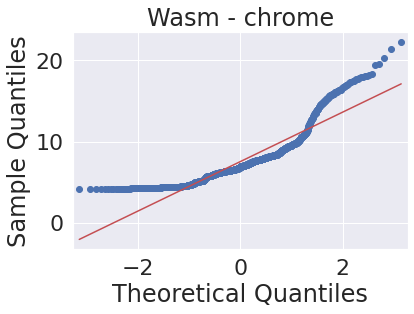

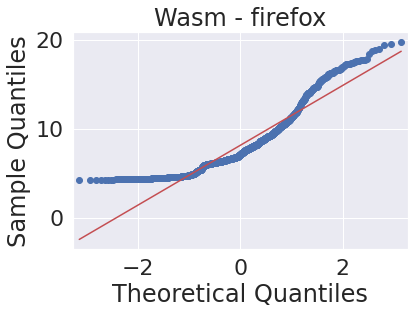

In [50]:
for browser in browsers:
    data = df[(df['implementation'] == 'wasm') & (df['browser'] == browser)]
    qq = sm.qqplot(data.energy, line='s')
    h = plt.title('Wasm - ' + browser)

## Q-Q-Plot (By Device)

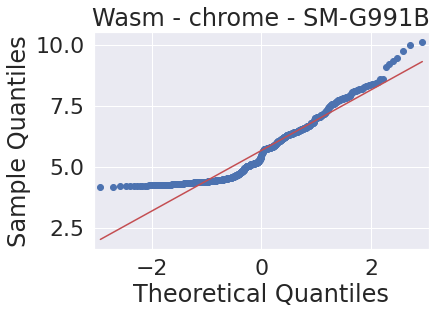

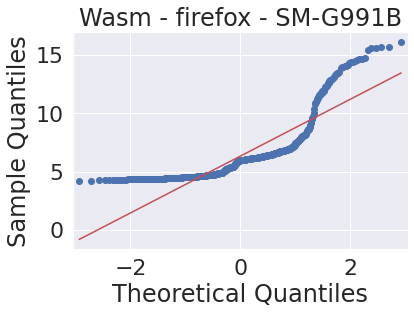

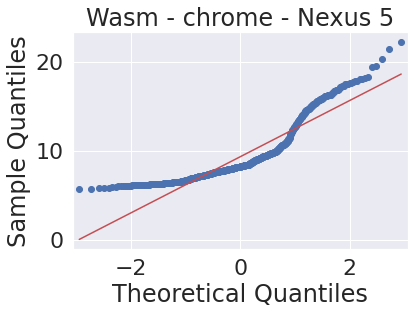

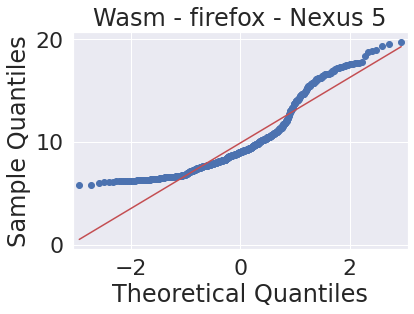

In [51]:
for device in devices:
    for browser in browsers:
        data = df[(df['implementation'] == 'wasm') & (df['browser'] == browser) & (df['device'] == device)]
        qq = sm.qqplot(data.energy, line='s')
        h = plt.title('Wasm - ' + browser + ' - ' + device)

## Histogram

(0.0, 30.0)

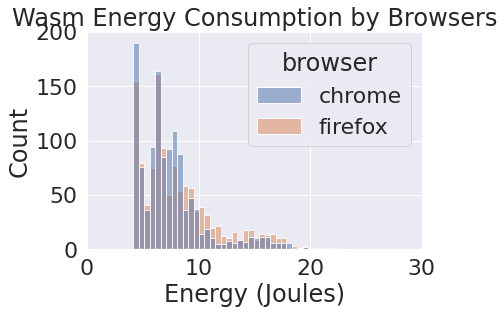

In [52]:
data = df[(df['implementation'] == 'wasm')]
sns.histplot(data=data, x="energy", hue="browser", hue_order=browsers).set_title("Wasm Energy Consumption by Browsers")
plt.xlabel("Energy (Joules)")
plt.ylim(0, 200)
plt.xlim(0, 30)

## Histogram (By Device)

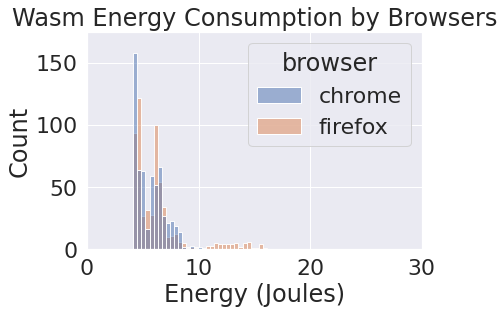

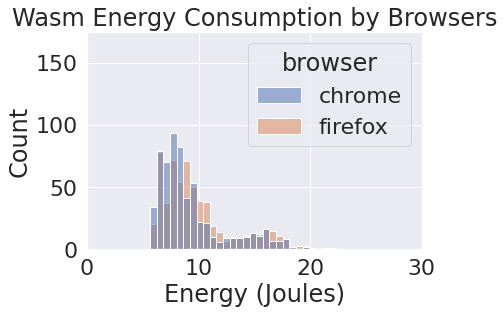

In [53]:
data = []
for device in devices:
    data = df[(df['implementation'] == 'wasm') & (df['device'] == device)]
    sns.histplot(data=data, x="energy", hue="browser", hue_order=browsers).set_title("Wasm Energy Consumption by Browsers")
    plt.xlabel("Energy (Joules)")
    plt.ylim(0, 175)
    plt.xlim(0, 30)
    plt.show()

## Descriptive Statistics

In [54]:
data = []
for browser in browsers:
    x = df[(df['browser'] == browser) & (df['implementation'] == 'wasm')]
    mean = numpy.round(numpy.mean(x['energy']), 2)
    median = numpy.round(numpy.median(x['energy']), 2)
    min = numpy.round(numpy.amin(x['energy']), 2)
    max = numpy.round(numpy.amax(x['energy']), 2)
    std = numpy.round(numpy.std(x['energy']), 2)
    sem = numpy.round(stats.sem(x['energy']), 2)
    q1 = numpy.round(numpy.quantile(x['energy'], 0.25), 2)
    q3 = numpy.round(numpy.quantile(x['energy'], 0.75), 2)
    
    data.append(
        [browser, mean, std, min, q1, median, q3, max, sem]
    )
        
# Create the pandas DataFrame
stat = pd.DataFrame(data, columns = ['browser', 'mean', 'std', 'min', 'q1', 'median', 'q3', 'max', 'sem'])
# display(stat)
print(stat.to_string())

# Alternative of pandas: x['energy'].describe()

   browser  mean   std   min    q1  median    q3    max   sem
0   chrome  7.55  3.04  4.16  5.64    6.85  8.37  22.29  0.09
1  firefox  8.14  3.36  4.22  5.96    7.09  9.67  19.78  0.10


## Descriptive Statistics Difference

In [55]:
data = []

for browserpair in browserpairs:
    browser1 = stat[(stat['browser'] == browserpair[0])]
    browser2 = stat[(stat['browser'] == browserpair[1])]
    
    mean_diff = browser1.iloc[0]['mean']-browser2.iloc[0]['mean']
    median_diff = browser1.iloc[0]['median']-browser2.iloc[0]['median']
    min_diff = browser1.iloc[0]['min']-browser2.iloc[0]['min']
    max_diff = browser1.iloc[0]['max']-browser2.iloc[0]['max']
    std_diff = browser1.iloc[0]['std']-browser2.iloc[0]['std']
    sem_diff = browser1.iloc[0]['sem']-browser2.iloc[0]['sem']
    q1_diff = browser1.iloc[0]['q1']-browser2.iloc[0]['q1']
    q3_diff = browser1.iloc[0]['q3']-browser2.iloc[0]['q3']

    data.append(
        [browserpair[0] + ' vs. ' + browserpair[1],
         numpy.round(mean_diff, 2),
         numpy.round(mean_diff/browser2.iloc[0]['mean']*100, 2),
         numpy.round(median_diff, 2),
         numpy.round(median_diff/browser2.iloc[0]['median']*100, 2),
         numpy.round(min_diff, 2),
         numpy.round(min_diff/browser2.iloc[0]['min']*100, 2),
         numpy.round(max_diff, 2),
         numpy.round(max_diff/browser2.iloc[0]['max']*100, 2),
         numpy.round(std_diff, 2),
         numpy.round(std_diff/browser2.iloc[0]['std']*100, 2),
         numpy.round(sem_diff, 2),
         numpy.round(sem_diff/browser2.iloc[0]['sem']*100, 2),
         numpy.round(q1_diff, 2),
         numpy.round(q1_diff/browser2.iloc[0]['q1']*100, 2),
         numpy.round(q3_diff, 2),
         numpy.round(q3_diff/browser2.iloc[0]['q3']*100, 2),
        ]
    )
        
# Create the pandas DataFrame
ut = pd.DataFrame(data, columns = ['rq','mean_diff','mean_diff%','median_diff','median_diff%','min_diff','min_diff%','max_diff','max_diff%','std_diff','std_diff%','sem_diff','sem_diff%','q1_diff','q1_diff%','q3_diff','q3_diff%'])
display(ut)
#print(ut.to_string())

,rq,mean_diff,mean_diff%,median_diff,median_diff%,min_diff,min_diff%,max_diff,max_diff%,std_diff,std_diff%,sem_diff,sem_diff%,q1_diff,q1_diff%,q3_diff,q3_diff%
0,chrome vs. firefox,-0.59,-7.25,-0.24,-3.39,-0.06,-1.42,2.51,12.69,-0.32,-9.52,-0.01,-10.0,-0.32,-5.37,-1.3,-13.44


## Descriptive Statistics (By Device)

In [56]:
data = []

for device in devices:
    for browser in browsers:
        x = df[(df['browser'] == browser) & (df['implementation'] == 'wasm') & (df['device'] == device)]
        mean = numpy.round(numpy.mean(x['energy']), 2)
        median = numpy.round(numpy.median(x['energy']), 2)
        min = numpy.round(numpy.amin(x['energy']), 2)
        max = numpy.round(numpy.amax(x['energy']), 2)
        std = numpy.round(numpy.std(x['energy']), 2)
        sem = numpy.round(stats.sem(x['energy']), 2)
        q1 = numpy.round(numpy.quantile(x['energy'], 0.25), 2)
        q3 = numpy.round(numpy.quantile(x['energy'], 0.75), 2)

        data.append(
            [device, browser, mean, std, min, q1, median, q3, max, sem]
        )
        
# Create the pandas DataFrame
stat = pd.DataFrame(data, columns = ['device', 'browser', 'mean', 'std', 'min', 'q1', 'median', 'q3', 'max', 'sem'])
# display(stat)
print(stat.to_string())

# Alternative of pandas: x['energy'].describe()

     device  browser  mean   std   min    q1  median     q3    max   sem
0  SM-G991B   chrome  5.67  1.25  4.16  4.49    5.47   6.46  10.14  0.05
1  SM-G991B  firefox  6.32  2.43  4.22  4.63    5.96   6.62  16.11  0.10
2   Nexus 5   chrome  9.34  3.16  5.67  7.23    8.24  10.02  22.29  0.13
3   Nexus 5  firefox  9.91  3.19  5.79  7.63    9.04  10.99  19.78  0.13


## Descriptive Statistics Difference (By Device)

In [57]:
data = []

for device in devices:
    for browserpair in browserpairs:
        browser1 = stat[(stat['browser'] == browserpair[0]) & (stat['device'] == device)]
        browser2 = stat[(stat['browser'] == browserpair[1]) & (stat['device'] == device)]

        mean_diff = browser1.iloc[0]['mean']-browser2.iloc[0]['mean']
        median_diff = browser1.iloc[0]['median']-browser2.iloc[0]['median']
        min_diff = browser1.iloc[0]['min']-browser2.iloc[0]['min']
        max_diff = browser1.iloc[0]['max']-browser2.iloc[0]['max']
        std_diff = browser1.iloc[0]['std']-browser2.iloc[0]['std']
        sem_diff = browser1.iloc[0]['sem']-browser2.iloc[0]['sem']
        q1_diff = browser1.iloc[0]['q1']-browser2.iloc[0]['q1']
        q3_diff = browser1.iloc[0]['q3']-browser2.iloc[0]['q3']

        data.append(
            [
             device,
             browserpair[0] + ' vs. ' + browserpair[1],
             numpy.round(mean_diff, 2),
             numpy.round(mean_diff/browser2.iloc[0]['mean']*100, 2),
             numpy.round(median_diff, 2),
             numpy.round(median_diff/browser2.iloc[0]['median']*100, 2),
             numpy.round(min_diff, 2),
             numpy.round(min_diff/browser2.iloc[0]['min']*100, 2),
             numpy.round(max_diff, 2),
             numpy.round(max_diff/browser2.iloc[0]['max']*100, 2),
             numpy.round(std_diff, 2),
             numpy.round(std_diff/browser2.iloc[0]['std']*100, 2),
             numpy.round(sem_diff, 2),
             numpy.round(sem_diff/browser2.iloc[0]['sem']*100, 2),
             numpy.round(q1_diff, 2),
             numpy.round(q1_diff/browser2.iloc[0]['q1']*100, 2),
             numpy.round(q3_diff, 2),
             numpy.round(q3_diff/browser2.iloc[0]['q3']*100, 2),
            ]
        )
        
# Create the pandas DataFrame
ut = pd.DataFrame(data, columns = ['device', 'rq','mean_diff','mean_diff%','median_diff','median_diff%','min_diff','min_diff%','max_diff','max_diff%','std_diff','std_diff%','sem_diff','sem_diff%','q1_diff','q1_diff%','q3_diff','q3_diff%'])
display(ut)
#print(ut.to_string())

,device,rq,mean_diff,mean_diff%,median_diff,median_diff%,min_diff,min_diff%,max_diff,max_diff%,std_diff,std_diff%,sem_diff,sem_diff%,q1_diff,q1_diff%,q3_diff,q3_diff%
0,SM-G991B,chrome vs. firefox,-0.65,-10.28,-0.49,-8.22,-0.06,-1.42,-5.97,-37.06,-1.18,-48.56,-0.05,-50.0,-0.14,-3.02,-0.16,-2.42
1,Nexus 5,chrome vs. firefox,-0.57,-5.75,-0.80,-8.85,-0.12,-2.07,2.51,12.69,-0.03,-0.94,0.00,0.0,-0.40,-5.24,-0.97,-8.83
